In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import seaborn as sns
import os
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from keras import utils 
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,Input
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model
import wandb
from wandb.keras import WandbCallback
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_dir = './data/Training/'
test_dir = './data/Testing/'

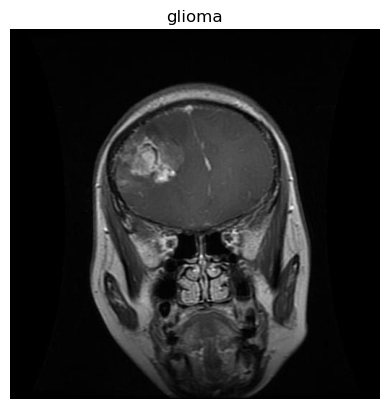

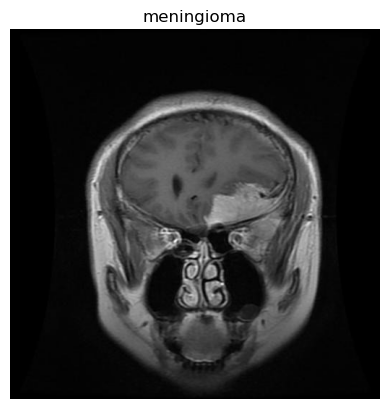

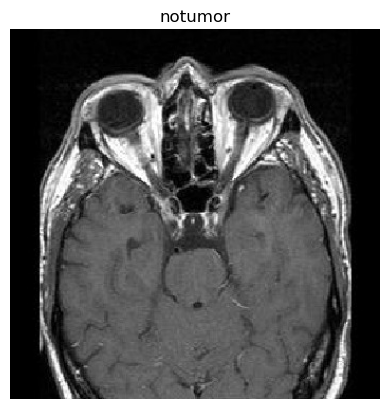

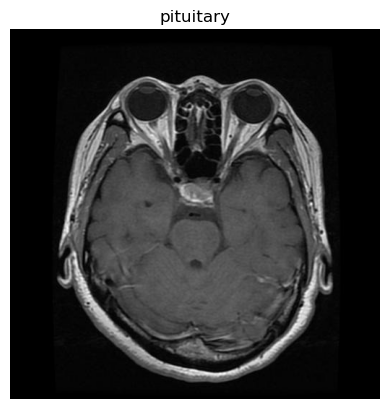

In [3]:
CATEGORIES = ["glioma","meningioma","notumor","pituitary"]
for category in CATEGORIES:
    path = os.path.join(train_dir,category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.imshow(img_array)
        plt.title(category)
        plt.axis("off")
        plt.show()
        break

In [4]:
IMG_SIZE = 150

In [5]:
training_data = []

for category in CATEGORIES:
    path = os.path.join(train_dir,category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE)) 
        training_data.append([new_array,class_num])

In [6]:
len(training_data)

5712

In [7]:
X = []
y = []
for features,label in training_data:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE)
print(X.shape)
X = X/255.0  
X = X.reshape(-1,150,150,1)
print(X.shape)

(5712, 150, 150)
(5712, 150, 150, 1)


In [8]:
y = to_categorical(y, num_classes = 4)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)
print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",y_train.shape)
print("y_test shape",y_val.shape)

x_train shape (4569, 150, 150, 1)
x_test shape (1143, 150, 150, 1)
y_train shape (4569, 4)
y_test shape (1143, 4)


In [10]:
wandb.login(relogin=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ········


wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\chels/.netrc


True

In [11]:
wandb.init(project='brain-tumor')

image_table = wandb.Table(columns=['image', 'label_id', 'class_name'])

for i in range(len(X_train)):
    image = X_train[i]
    label = np.argmax(y_train[i])  
    class_name = CATEGORIES[label] 
    image_table.add_data(wandb.Image(image), label, class_name)

artifact = wandb.Artifact('brain-tumor-dataset', type='dataset')

artifact.add(image_table, 'images')

wandb.log_artifact(artifact)

wandb.finish()

wandb: Currently logged in as: chelseahaddad (chelseahaddadd). Use `wandb login --relogin` to force relogin


In [12]:
sweep_config = {
    'method' : 'random',
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'
    },
    'parameters': {
        'epochs': {
            'values': [5,10]
        },
        'batch_size': {
            'values': [64, 32]
        },
        'learning_rate': {
            'values': [1e-2, 1e-3, 1e-4]
        
        }
    }
}

We specified the parameters to search through, the search strategy, the optimization metric,...

In [13]:
sweep_id = wandb.sweep(sweep_config, project="brain-tumor")

Create sweep with ID: ifc2nd68
Sweep URL: https://wandb.ai/chelseahaddadd/brain-tumor/sweeps/ifc2nd68


In [14]:
def train():
    
    config_defaults = {
        'epochs': 10,
        'batch_size': 32,
        'learning_rate': 1e-3
    }

    wandb.init(config=config_defaults)
    
    config = wandb.config
    
    model = Sequential()

    model.add(Conv2D(filters =64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = (150,150,1)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.3))


    model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.3))


    model.add(Flatten())
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation = "softmax"))

    optimizer = Adam(lr=config.learning_rate, beta_1=0.9, beta_2=0.999)

    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=['accuracy', 
                                                                   tf.keras.metrics.Precision(0.5),
                                                                   tf.keras.metrics.Recall(0.5)])
    
    model.fit(X_train, y_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val, y_val),
              callbacks=[WandbCallback(),
                         tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)])

In [15]:
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: jhzev4qe with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
72/72 [==============================] - ETA: 0s - loss: 1.1040 - accuracy: 0.5076 - precision: 0.7335 - recall: 0.2561

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_124042-jhzev4qe\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_124042-jhzev4qe\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_124042-jhzev4qe\files\model-best)... Done. 0.1s


72/72 [==============================] - 139s 2s/step - loss: 1.1040 - accuracy: 0.5076 - precision: 0.7335 - recall: 0.2561 - val_loss: 0.9969 - val_accuracy: 0.5529 - val_precision: 0.6132 - val_recall: 0.4549
Epoch 2/10
72/72 [==============================] - ETA: 0s - loss: 0.6798 - accuracy: 0.7354 - precision: 0.7824 - recall: 0.6667

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_124042-jhzev4qe\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_124042-jhzev4qe\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_124042-jhzev4qe\files\model-best)... Done. 0.1s


72/72 [==============================] - 140s 2s/step - loss: 0.6798 - accuracy: 0.7354 - precision: 0.7824 - recall: 0.6667 - val_loss: 0.5620 - val_accuracy: 0.7734 - val_precision: 0.8152 - val_recall: 0.7060
Epoch 3/10
72/72 [==============================] - 136s 2s/step - loss: 0.5179 - accuracy: 0.7993 - precision: 0.8213 - recall: 0.7663 - val_loss: 0.7472 - val_accuracy: 0.6903 - val_precision: 0.7137 - val_recall: 0.6588
Epoch 4/10
72/72 [==============================] - ETA: 0s - loss: 0.4387 - accuracy: 0.8317 - precision: 0.8509 - recall: 0.8091

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_124042-jhzev4qe\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_124042-jhzev4qe\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_124042-jhzev4qe\files\model-best)... Done. 0.1s


72/72 [==============================] - 139s 2s/step - loss: 0.4387 - accuracy: 0.8317 - precision: 0.8509 - recall: 0.8091 - val_loss: 0.3332 - val_accuracy: 0.8688 - val_precision: 0.8724 - val_recall: 0.8495
Epoch 5/10
72/72 [==============================] - ETA: 0s - loss: 0.3693 - accuracy: 0.8591 - precision: 0.8744 - recall: 0.8475

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_124042-jhzev4qe\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_124042-jhzev4qe\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_124042-jhzev4qe\files\model-best)... Done. 0.1s


72/72 [==============================] - 140s 2s/step - loss: 0.3693 - accuracy: 0.8591 - precision: 0.8744 - recall: 0.8475 - val_loss: 0.2943 - val_accuracy: 0.8968 - val_precision: 0.9094 - val_recall: 0.8871
Epoch 6/10
72/72 [==============================] - ETA: 0s - loss: 0.2844 - accuracy: 0.8969 - precision: 0.9063 - recall: 0.8890

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_124042-jhzev4qe\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_124042-jhzev4qe\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_124042-jhzev4qe\files\model-best)... Done. 0.1s


72/72 [==============================] - 140s 2s/step - loss: 0.2844 - accuracy: 0.8969 - precision: 0.9063 - recall: 0.8890 - val_loss: 0.2299 - val_accuracy: 0.9081 - val_precision: 0.9150 - val_recall: 0.9038
Epoch 7/10
72/72 [==============================] - ETA: 0s - loss: 0.2504 - accuracy: 0.9094 - precision: 0.9153 - recall: 0.9009

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_124042-jhzev4qe\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_124042-jhzev4qe\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_124042-jhzev4qe\files\model-best)... Done. 0.1s


72/72 [==============================] - 139s 2s/step - loss: 0.2504 - accuracy: 0.9094 - precision: 0.9153 - recall: 0.9009 - val_loss: 0.2268 - val_accuracy: 0.9073 - val_precision: 0.9126 - val_recall: 0.9046
Epoch 8/10
72/72 [==============================] - ETA: 0s - loss: 0.2103 - accuracy: 0.9273 - precision: 0.9323 - recall: 0.9216

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_124042-jhzev4qe\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_124042-jhzev4qe\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_124042-jhzev4qe\files\model-best)... Done. 0.1s


72/72 [==============================] - 148s 2s/step - loss: 0.2103 - accuracy: 0.9273 - precision: 0.9323 - recall: 0.9216 - val_loss: 0.1768 - val_accuracy: 0.9300 - val_precision: 0.9308 - val_recall: 0.9300
Epoch 9/10
72/72 [==============================] - 137s 2s/step - loss: 0.1826 - accuracy: 0.9339 - precision: 0.9380 - recall: 0.9302 - val_loss: 0.1884 - val_accuracy: 0.9318 - val_precision: 0.9365 - val_recall: 0.9291
Epoch 10/10
72/72 [==============================] - 138s 2s/step - loss: 0.1664 - accuracy: 0.9442 - precision: 0.9465 - recall: 0.9402 - val_loss: 0.1849 - val_accuracy: 0.9283 - val_precision: 0.9313 - val_recall: 0.9256


accuracy,▁▅▆▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▁▁▁
precision,▁▃▄▅▆▇▇███
recall,▁▅▆▇▇▇████
val_accuracy,▁▅▄▇▇█████
val_loss,█▄▆▂▂▁▁▁▁▁
val_precision,▁▅▃▇▇█▇███
val_recall,▁▅▄▇▇█████
accuracy,0.94419
best_epoch,7


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pwkrwjs5 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01


Epoch 1/10
143/143 [==============================] - ETA: 0s - loss: 5.1006 - accuracy: 0.2594 - precision: 0.3846 - recall: 0.0109

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_130551-pwkrwjs5\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_130551-pwkrwjs5\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_130551-pwkrwjs5\files\model-best)... Done. 0.1s


143/143 [==============================] - 140s 977ms/step - loss: 5.1006 - accuracy: 0.2594 - precision: 0.3846 - recall: 0.0109 - val_loss: 1.3918 - val_accuracy: 0.2546 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
143/143 [==============================] - ETA: 0s - loss: 1.3847 - accuracy: 0.2808 - precision: 0.0000e+00 - recall: 0.0000e+00

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_130551-pwkrwjs5\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_130551-pwkrwjs5\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_130551-pwkrwjs5\files\model-best)... Done. 0.1s


143/143 [==============================] - 140s 978ms/step - loss: 1.3847 - accuracy: 0.2808 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3897 - val_accuracy: 0.2546 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
143/143 [==============================] - ETA: 0s - loss: 1.3834 - accuracy: 0.2854 - precision: 0.0000e+00 - recall: 0.0000e+00

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_130551-pwkrwjs5\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_130551-pwkrwjs5\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_130551-pwkrwjs5\files\model-best)... Done. 0.1s


143/143 [==============================] - 142s 996ms/step - loss: 1.3834 - accuracy: 0.2854 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3879 - val_accuracy: 0.2546 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
143/143 [==============================] - 141s 986ms/step - loss: 1.3831 - accuracy: 0.2854 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3906 - val_accuracy: 0.2546 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
143/143 [==============================] - 141s 984ms/step - loss: 1.3832 - accuracy: 0.2854 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3893 - val_accuracy: 0.2546 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/10
143/143 [==============================] - 141s 985ms/step - loss: 1.3831 - accuracy: 0.2782 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3879 - val_accuracy: 0.2546 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


accuracy,▁▇███▆
epoch,▁▂▄▅▇█
loss,█▁▁▁▁▁
precision,█▁▁▁▁▁
recall,█▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁
val_loss,█▄▁▆▄▁
val_precision,▁▁▁▁▁▁
val_recall,▁▁▁▁▁▁
accuracy,0.27818
best_epoch,2


wandb: Agent Starting Run: dicwa31f with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001


Epoch 1/5
72/72 [==============================] - ETA: 0s - loss: 1.0961 - accuracy: 0.4997 - precision: 0.7201 - recall: 0.2692

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_132142-dicwa31f\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_132142-dicwa31f\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_132142-dicwa31f\files\model-best)... Done. 0.1s


72/72 [==============================] - 141s 2s/step - loss: 1.0961 - accuracy: 0.4997 - precision: 0.7201 - recall: 0.2692 - val_loss: 0.9867 - val_accuracy: 0.5608 - val_precision: 0.6437 - val_recall: 0.4584
Epoch 2/5
72/72 [==============================] - ETA: 0s - loss: 0.6448 - accuracy: 0.7468 - precision: 0.7925 - recall: 0.6881

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_132142-dicwa31f\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_132142-dicwa31f\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_132142-dicwa31f\files\model-best)... Done. 0.1s


72/72 [==============================] - 145s 2s/step - loss: 0.6448 - accuracy: 0.7468 - precision: 0.7925 - recall: 0.6881 - val_loss: 0.6979 - val_accuracy: 0.6763 - val_precision: 0.7221 - val_recall: 0.6229
Epoch 3/5
72/72 [==============================] - ETA: 0s - loss: 0.5004 - accuracy: 0.8109 - precision: 0.8367 - recall: 0.7805

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_132142-dicwa31f\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_132142-dicwa31f\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_132142-dicwa31f\files\model-best)... Done. 0.1s


72/72 [==============================] - 142s 2s/step - loss: 0.5004 - accuracy: 0.8109 - precision: 0.8367 - recall: 0.7805 - val_loss: 0.6377 - val_accuracy: 0.7200 - val_precision: 0.7469 - val_recall: 0.6789
Epoch 4/5
72/72 [==============================] - ETA: 0s - loss: 0.4568 - accuracy: 0.8240 - precision: 0.8426 - recall: 0.8000

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_132142-dicwa31f\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_132142-dicwa31f\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_132142-dicwa31f\files\model-best)... Done. 0.1s


72/72 [==============================] - 144s 2s/step - loss: 0.4568 - accuracy: 0.8240 - precision: 0.8426 - recall: 0.8000 - val_loss: 0.4712 - val_accuracy: 0.7988 - val_precision: 0.8198 - val_recall: 0.7760
Epoch 5/5
72/72 [==============================] - ETA: 0s - loss: 0.3665 - accuracy: 0.8599 - precision: 0.8740 - recall: 0.8472

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_132142-dicwa31f\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_132142-dicwa31f\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_132142-dicwa31f\files\model-best)... Done. 0.1s


72/72 [==============================] - 144s 2s/step - loss: 0.3665 - accuracy: 0.8599 - precision: 0.8740 - recall: 0.8472 - val_loss: 0.3980 - val_accuracy: 0.8399 - val_precision: 0.8553 - val_recall: 0.8224


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
loss,█▄▂▂▁
precision,▁▄▆▇█
recall,▁▆▇▇█
val_accuracy,▁▄▅▇█
val_loss,█▅▄▂▁
val_precision,▁▄▄▇█
val_recall,▁▄▅▇█
accuracy,0.85993
best_epoch,4


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0pqfgjur with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01


Epoch 1/10
143/143 [==============================] - ETA: 0s - loss: 3.4384 - accuracy: 0.2707 - precision: 0.3016 - recall: 0.0042

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_133830-0pqfgjur\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_133830-0pqfgjur\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_133830-0pqfgjur\files\model-best)... Done. 0.1s


143/143 [==============================] - 141s 983ms/step - loss: 3.4384 - accuracy: 0.2707 - precision: 0.3016 - recall: 0.0042 - val_loss: 1.3883 - val_accuracy: 0.2546 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
143/143 [==============================] - ETA: 0s - loss: 1.3834 - accuracy: 0.2823 - precision: 0.0000e+00 - recall: 0.0000e+00

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_133830-0pqfgjur\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_133830-0pqfgjur\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_133830-0pqfgjur\files\model-best)... Done. 0.1s


143/143 [==============================] - 142s 994ms/step - loss: 1.3834 - accuracy: 0.2823 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3863 - val_accuracy: 0.2546 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
143/143 [==============================] - 141s 989ms/step - loss: 1.3838 - accuracy: 0.2852 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3866 - val_accuracy: 0.2546 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
143/143 [==============================] - 143s 998ms/step - loss: 1.3837 - accuracy: 0.2854 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3883 - val_accuracy: 0.2546 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
143/143 [==============================] - 143s 1s/step - loss: 1.3829 - accuracy: 0.2854 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3894 - val_accuracy: 0.2546 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/10
143/143 [==================

accuracy,▁▇████
epoch,▁▂▄▅▇█
loss,█▁▁▁▁▁
precision,█▁▁▁▁▁
recall,█▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁
val_loss,▄▁▂▄▅█
val_precision,▁▁▁▁▁▁
val_recall,▁▁▁▁▁▁
accuracy,0.2854
best_epoch,1


wandb: Agent Starting Run: 1ydw64cc with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001


Epoch 1/5
143/143 [==============================] - ETA: 0s - loss: 1.2292 - accuracy: 0.4003 - precision: 0.7012 - recall: 0.1186

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_135459-1ydw64cc\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_135459-1ydw64cc\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_135459-1ydw64cc\files\model-best)... Done. 0.1s


143/143 [==============================] - 143s 995ms/step - loss: 1.2292 - accuracy: 0.4003 - precision: 0.7012 - recall: 0.1186 - val_loss: 1.1469 - val_accuracy: 0.5127 - val_precision: 0.5548 - val_recall: 0.0709
Epoch 2/5
143/143 [==============================] - ETA: 0s - loss: 0.9143 - accuracy: 0.6253 - precision: 0.7371 - recall: 0.4406

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_135459-1ydw64cc\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_135459-1ydw64cc\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_135459-1ydw64cc\files\model-best)... Done. 0.1s


143/143 [==============================] - 145s 1s/step - loss: 0.9143 - accuracy: 0.6253 - precision: 0.7371 - recall: 0.4406 - val_loss: 1.0848 - val_accuracy: 0.5171 - val_precision: 0.5449 - val_recall: 0.3876
Epoch 3/5
143/143 [==============================] - ETA: 0s - loss: 0.7235 - accuracy: 0.7177 - precision: 0.7775 - recall: 0.6457

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_135459-1ydw64cc\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_135459-1ydw64cc\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_135459-1ydw64cc\files\model-best)... Done. 0.1s


143/143 [==============================] - 148s 1s/step - loss: 0.7235 - accuracy: 0.7177 - precision: 0.7775 - recall: 0.6457 - val_loss: 0.7036 - val_accuracy: 0.7139 - val_precision: 0.8007 - val_recall: 0.6115
Epoch 4/5
143/143 [==============================] - 147s 1s/step - loss: 0.6402 - accuracy: 0.7533 - precision: 0.7961 - recall: 0.6929 - val_loss: 0.8171 - val_accuracy: 0.6282 - val_precision: 0.6694 - val_recall: 0.5669
Epoch 5/5
143/143 [==============================] - ETA: 0s - loss: 0.5755 - accuracy: 0.7754 - precision: 0.8151 - recall: 0.7321

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_135459-1ydw64cc\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_135459-1ydw64cc\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_135459-1ydw64cc\files\model-best)... Done. 0.1s


143/143 [==============================] - 149s 1s/step - loss: 0.5755 - accuracy: 0.7754 - precision: 0.8151 - recall: 0.7321 - val_loss: 0.6102 - val_accuracy: 0.7393 - val_precision: 0.7907 - val_recall: 0.6675


accuracy,▁▅▇██
epoch,▁▃▅▆█
loss,█▅▃▂▁
precision,▁▃▆▇█
recall,▁▅▇██
val_accuracy,▁▁▇▅█
val_loss,█▇▂▄▁
val_precision,▁▁█▄█
val_recall,▁▅▇▇█
accuracy,0.77544
best_epoch,4


wandb: Agent Starting Run: o1hwsggt with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001


Epoch 1/5
72/72 [==============================] - ETA: 0s - loss: 1.1026 - accuracy: 0.5025 - precision: 0.7462 - recall: 0.2594

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_141054-o1hwsggt\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_141054-o1hwsggt\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_141054-o1hwsggt\files\model-best)... Done. 0.1s


72/72 [==============================] - 138s 2s/step - loss: 1.1026 - accuracy: 0.5025 - precision: 0.7462 - recall: 0.2594 - val_loss: 1.2379 - val_accuracy: 0.3955 - val_precision: 0.4525 - val_recall: 0.3167
Epoch 2/5
72/72 [==============================] - ETA: 0s - loss: 0.6857 - accuracy: 0.7395 - precision: 0.7893 - recall: 0.6699

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_141054-o1hwsggt\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_141054-o1hwsggt\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_141054-o1hwsggt\files\model-best)... Done. 0.1s


72/72 [==============================] - 139s 2s/step - loss: 0.6857 - accuracy: 0.7395 - precision: 0.7893 - recall: 0.6699 - val_loss: 1.1047 - val_accuracy: 0.5416 - val_precision: 0.5815 - val_recall: 0.4961
Epoch 3/5
72/72 [==============================] - ETA: 0s - loss: 0.5305 - accuracy: 0.7951 - precision: 0.8235 - recall: 0.7579

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_141054-o1hwsggt\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_141054-o1hwsggt\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_141054-o1hwsggt\files\model-best)... Done. 0.1s


72/72 [==============================] - 142s 2s/step - loss: 0.5305 - accuracy: 0.7951 - precision: 0.8235 - recall: 0.7579 - val_loss: 0.6987 - val_accuracy: 0.6920 - val_precision: 0.7304 - val_recall: 0.6614
Epoch 4/5
72/72 [==============================] - 142s 2s/step - loss: 0.4957 - accuracy: 0.8094 - precision: 0.8343 - recall: 0.7770 - val_loss: 0.7036 - val_accuracy: 0.7340 - val_precision: 0.7486 - val_recall: 0.7113
Epoch 5/5
72/72 [==============================] - ETA: 0s - loss: 0.3922 - accuracy: 0.8542 - precision: 0.8669 - recall: 0.8369

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_141054-o1hwsggt\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_141054-o1hwsggt\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_141054-o1hwsggt\files\model-best)... Done. 0.1s


72/72 [==============================] - 143s 2s/step - loss: 0.3922 - accuracy: 0.8542 - precision: 0.8669 - recall: 0.8369 - val_loss: 0.4664 - val_accuracy: 0.7979 - val_precision: 0.8152 - val_recall: 0.7795


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
loss,█▄▂▂▁
precision,▁▃▅▆█
recall,▁▆▇▇█
val_accuracy,▁▄▆▇█
val_loss,█▇▃▃▁
val_precision,▁▃▆▇█
val_recall,▁▄▆▇█
accuracy,0.85424
best_epoch,4


wandb: Agent Starting Run: qw4ab3o2 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001


Epoch 1/10
72/72 [==============================] - ETA: 0s - loss: 1.2945 - accuracy: 0.3333 - precision: 0.6950 - recall: 0.0519

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_142636-qw4ab3o2\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_142636-qw4ab3o2\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_142636-qw4ab3o2\files\model-best)... Done. 0.1s


72/72 [==============================] - 141s 2s/step - loss: 1.2945 - accuracy: 0.3333 - precision: 0.6950 - recall: 0.0519 - val_loss: 1.2280 - val_accuracy: 0.4532 - val_precision: 0.2353 - val_recall: 0.0035
Epoch 2/10
72/72 [==============================] - ETA: 0s - loss: 1.0779 - accuracy: 0.5222 - precision: 0.7012 - recall: 0.2605

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_142636-qw4ab3o2\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_142636-qw4ab3o2\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_142636-qw4ab3o2\files\model-best)... Done. 0.1s


72/72 [==============================] - 146s 2s/step - loss: 1.0779 - accuracy: 0.5222 - precision: 0.7012 - recall: 0.2605 - val_loss: 1.0055 - val_accuracy: 0.6028 - val_precision: 0.8387 - val_recall: 0.2047
Epoch 3/10
72/72 [==============================] - ETA: 0s - loss: 0.8486 - accuracy: 0.6638 - precision: 0.7576 - recall: 0.5034

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_142636-qw4ab3o2\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_142636-qw4ab3o2\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_142636-qw4ab3o2\files\model-best)... Done. 0.1s


72/72 [==============================] - 146s 2s/step - loss: 0.8486 - accuracy: 0.6638 - precision: 0.7576 - recall: 0.5034 - val_loss: 0.8859 - val_accuracy: 0.6238 - val_precision: 0.7251 - val_recall: 0.5214
Epoch 4/10
72/72 [==============================] - ETA: 0s - loss: 0.7273 - accuracy: 0.7185 - precision: 0.7759 - recall: 0.6312

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_142636-qw4ab3o2\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_142636-qw4ab3o2\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_142636-qw4ab3o2\files\model-best)... Done. 0.1s


72/72 [==============================] - 148s 2s/step - loss: 0.7273 - accuracy: 0.7185 - precision: 0.7759 - recall: 0.6312 - val_loss: 0.8809 - val_accuracy: 0.6115 - val_precision: 0.6685 - val_recall: 0.5433
Epoch 5/10
72/72 [==============================] - ETA: 0s - loss: 0.6690 - accuracy: 0.7374 - precision: 0.7840 - recall: 0.6721

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_142636-qw4ab3o2\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_142636-qw4ab3o2\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_142636-qw4ab3o2\files\model-best)... Done. 0.1s


72/72 [==============================] - 147s 2s/step - loss: 0.6690 - accuracy: 0.7374 - precision: 0.7840 - recall: 0.6721 - val_loss: 0.6502 - val_accuracy: 0.7262 - val_precision: 0.7989 - val_recall: 0.6430
Epoch 6/10
72/72 [==============================] - 144s 2s/step - loss: 0.6057 - accuracy: 0.7715 - precision: 0.8102 - recall: 0.7185 - val_loss: 0.6651 - val_accuracy: 0.7052 - val_precision: 0.7447 - val_recall: 0.6509
Epoch 7/10
72/72 [==============================] - ETA: 0s - loss: 0.5608 - accuracy: 0.7816 - precision: 0.8197 - recall: 0.7441

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_142636-qw4ab3o2\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_142636-qw4ab3o2\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_142636-qw4ab3o2\files\model-best)... Done. 0.1s


72/72 [==============================] - 146s 2s/step - loss: 0.5608 - accuracy: 0.7816 - precision: 0.8197 - recall: 0.7441 - val_loss: 0.5691 - val_accuracy: 0.7629 - val_precision: 0.8158 - val_recall: 0.6973
Epoch 8/10
72/72 [==============================] - ETA: 0s - loss: 0.5247 - accuracy: 0.7971 - precision: 0.8243 - recall: 0.7597

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_142636-qw4ab3o2\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_142636-qw4ab3o2\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_142636-qw4ab3o2\files\model-best)... Done. 0.1s


72/72 [==============================] - 147s 2s/step - loss: 0.5247 - accuracy: 0.7971 - precision: 0.8243 - recall: 0.7597 - val_loss: 0.5402 - val_accuracy: 0.7655 - val_precision: 0.7961 - val_recall: 0.7104
Epoch 9/10
72/72 [==============================] - 144s 2s/step - loss: 0.5029 - accuracy: 0.8089 - precision: 0.8358 - recall: 0.7763 - val_loss: 0.5888 - val_accuracy: 0.7279 - val_precision: 0.7526 - val_recall: 0.6868
Epoch 10/10
72/72 [==============================] - ETA: 0s - loss: 0.4729 - accuracy: 0.8229 - precision: 0.8489 - recall: 0.7969

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_142636-qw4ab3o2\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_142636-qw4ab3o2\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_142636-qw4ab3o2\files\model-best)... Done. 0.1s


72/72 [==============================] - 146s 2s/step - loss: 0.4729 - accuracy: 0.8229 - precision: 0.8489 - recall: 0.7969 - val_loss: 0.4805 - val_accuracy: 0.8110 - val_precision: 0.8374 - val_recall: 0.7524


accuracy,▁▄▆▇▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▃▃▂▂▁▁▁
precision,▁▁▄▅▅▆▇▇▇█
recall,▁▃▅▆▇▇████
val_accuracy,▁▄▄▄▆▆▇▇▆█
val_loss,█▆▅▅▃▃▂▂▂▁
val_precision,▁█▇▆█▇██▇█
val_recall,▁▃▆▆▇▇▇█▇█
accuracy,0.82294
best_epoch,9


wandb: Agent Starting Run: 045pl6d1 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001


Epoch 1/5
143/143 [==============================] - ETA: 0s - loss: 1.2438 - accuracy: 0.3861 - precision: 0.6722 - recall: 0.0983

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_145350-045pl6d1\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_145350-045pl6d1\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_145350-045pl6d1\files\model-best)... Done. 0.1s


143/143 [==============================] - 145s 1s/step - loss: 1.2438 - accuracy: 0.3861 - precision: 0.6722 - recall: 0.0983 - val_loss: 1.1534 - val_accuracy: 0.6019 - val_precision: 0.3143 - val_recall: 0.0096
Epoch 2/5
143/143 [==============================] - ETA: 0s - loss: 0.9243 - accuracy: 0.6277 - precision: 0.7352 - recall: 0.4539

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_145350-045pl6d1\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_145350-045pl6d1\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_145350-045pl6d1\files\model-best)... Done. 0.1s


143/143 [==============================] - 146s 1s/step - loss: 0.9243 - accuracy: 0.6277 - precision: 0.7352 - recall: 0.4539 - val_loss: 0.9501 - val_accuracy: 0.6045 - val_precision: 0.7152 - val_recall: 0.3998
Epoch 3/5
143/143 [==============================] - ETA: 0s - loss: 0.7576 - accuracy: 0.7115 - precision: 0.7763 - recall: 0.6214

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_145350-045pl6d1\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_145350-045pl6d1\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_145350-045pl6d1\files\model-best)... Done. 0.1s


143/143 [==============================] - 149s 1s/step - loss: 0.7576 - accuracy: 0.7115 - precision: 0.7763 - recall: 0.6214 - val_loss: 0.8531 - val_accuracy: 0.6352 - val_precision: 0.6967 - val_recall: 0.5547
Epoch 4/5
143/143 [==============================] - ETA: 0s - loss: 0.6544 - accuracy: 0.7505 - precision: 0.7976 - recall: 0.6857

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_145350-045pl6d1\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_145350-045pl6d1\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_145350-045pl6d1\files\model-best)... Done. 0.1s


143/143 [==============================] - 149s 1s/step - loss: 0.6544 - accuracy: 0.7505 - precision: 0.7976 - recall: 0.6857 - val_loss: 0.7526 - val_accuracy: 0.6667 - val_precision: 0.7055 - val_recall: 0.5993
Epoch 5/5
143/143 [==============================] - ETA: 0s - loss: 0.6054 - accuracy: 0.7693 - precision: 0.8077 - recall: 0.7170

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_145350-045pl6d1\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_145350-045pl6d1\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_145350-045pl6d1\files\model-best)... Done. 0.1s


143/143 [==============================] - 149s 1s/step - loss: 0.6054 - accuracy: 0.7693 - precision: 0.8077 - recall: 0.7170 - val_loss: 0.6560 - val_accuracy: 0.7200 - val_precision: 0.7750 - val_recall: 0.6509


accuracy,▁▅▇██
epoch,▁▃▅▆█
loss,█▄▃▂▁
precision,▁▄▆▇█
recall,▁▅▇██
val_accuracy,▁▁▃▅█
val_loss,█▅▄▂▁
val_precision,▁▇▇▇█
val_recall,▁▅▇▇█
accuracy,0.76931
best_epoch,4


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: er3yfwd1 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01


Epoch 1/10
143/143 [==============================] - ETA: 0s - loss: 3.3929 - accuracy: 0.2766 - precision: 0.2188 - recall: 0.0015

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_151024-er3yfwd1\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_151024-er3yfwd1\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_151024-er3yfwd1\files\model-best)... Done. 0.1s


143/143 [==============================] - 140s 975ms/step - loss: 3.3929 - accuracy: 0.2766 - precision: 0.2188 - recall: 0.0015 - val_loss: 1.3912 - val_accuracy: 0.2546 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
143/143 [==============================] - ETA: 0s - loss: 1.3847 - accuracy: 0.2797 - precision: 0.0000e+00 - recall: 0.0000e+00

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_151024-er3yfwd1\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_151024-er3yfwd1\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_151024-er3yfwd1\files\model-best)... Done. 0.1s


143/143 [==============================] - 142s 994ms/step - loss: 1.3847 - accuracy: 0.2797 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3896 - val_accuracy: 0.2546 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
143/143 [==============================] - ETA: 0s - loss: 1.3832 - accuracy: 0.2823 - precision: 0.0000e+00 - recall: 0.0000e+00

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_151024-er3yfwd1\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_151024-er3yfwd1\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_151024-er3yfwd1\files\model-best)... Done. 0.1s


143/143 [==============================] - 145s 1s/step - loss: 1.3832 - accuracy: 0.2823 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3884 - val_accuracy: 0.2546 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
143/143 [==============================] - 144s 1s/step - loss: 1.3838 - accuracy: 0.2826 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3894 - val_accuracy: 0.2546 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
143/143 [==============================] - 143s 1s/step - loss: 1.3837 - accuracy: 0.2854 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3896 - val_accuracy: 0.2546 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/10
143/143 [==============================] - ETA: 0s - loss: 1.3836 - accuracy: 0.2854 - precision: 0.0000e+00 - recall: 0.0000e+00

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_151024-er3yfwd1\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_151024-er3yfwd1\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_151024-er3yfwd1\files\model-best)... Done. 0.1s


143/143 [==============================] - 145s 1s/step - loss: 1.3836 - accuracy: 0.2854 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3882 - val_accuracy: 0.2546 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


accuracy,▁▃▆▆██
epoch,▁▂▄▅▇█
loss,█▁▁▁▁▁
precision,█▁▁▁▁▁
recall,█▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁
val_loss,█▄▂▄▄▁
val_precision,▁▁▁▁▁▁
val_recall,▁▁▁▁▁▁
accuracy,0.2854
best_epoch,5


wandb: Agent Starting Run: y1ffawj2 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01


Epoch 1/10
72/72 [==============================] - ETA: 0s - loss: 2.3291 - accuracy: 0.2766 - precision: 0.4375 - recall: 0.0169

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_152739-y1ffawj2\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_152739-y1ffawj2\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_152739-y1ffawj2\files\model-best)... Done. 0.1s


72/72 [==============================] - 137s 2s/step - loss: 2.3291 - accuracy: 0.2766 - precision: 0.4375 - recall: 0.0169 - val_loss: 1.3875 - val_accuracy: 0.2616 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
72/72 [==============================] - ETA: 0s - loss: 1.3768 - accuracy: 0.2882 - precision: 0.7143 - recall: 0.0230

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_152739-y1ffawj2\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_152739-y1ffawj2\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_152739-y1ffawj2\files\model-best)... Done. 0.1s


72/72 [==============================] - 139s 2s/step - loss: 1.3768 - accuracy: 0.2882 - precision: 0.7143 - recall: 0.0230 - val_loss: 1.3874 - val_accuracy: 0.2546 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
72/72 [==============================] - 139s 2s/step - loss: 1.3847 - accuracy: 0.2729 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3874 - val_accuracy: 0.2546 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
72/72 [==============================] - 140s 2s/step - loss: 1.3832 - accuracy: 0.2854 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3877 - val_accuracy: 0.2546 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
72/72 [==============================] - 139s 2s/step - loss: 1.3830 - accuracy: 0.2854 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3879 - val_accuracy: 0.2546 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/10
72/72 [==============================] - 139s 2s/ste

accuracy,▃█▁▇▇▇
epoch,▁▂▄▅▇█
loss,█▁▁▁▁▁
precision,▅█▁▁▁▁
recall,▆█▁▁▁▁
val_accuracy,█▁▁▁▁▁
val_loss,▃▁▂▅█▁
val_precision,▁▁▁▁▁▁
val_recall,▁▁▁▁▁▁
accuracy,0.2854
best_epoch,1


wandb: Agent Starting Run: zquryg8s with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01


Epoch 1/10
72/72 [==============================] - ETA: 0s - loss: 8.9361 - accuracy: 0.2751 - precision: 0.2174 - recall: 0.0033

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_154329-zquryg8s\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_154329-zquryg8s\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_154329-zquryg8s\files\model-best)... Done. 0.1s


72/72 [==============================] - 141s 2s/step - loss: 8.9361 - accuracy: 0.2751 - precision: 0.2174 - recall: 0.0033 - val_loss: 1.3870 - val_accuracy: 0.2546 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
72/72 [==============================] - 136s 2s/step - loss: 1.3841 - accuracy: 0.2847 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3889 - val_accuracy: 0.2546 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
72/72 [==============================] - 139s 2s/step - loss: 1.3828 - accuracy: 0.2854 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3898 - val_accuracy: 0.2546 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
72/72 [==============================] - 140s 2s/step - loss: 1.3829 - accuracy: 0.2854 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3886 - val_accuracy: 0.2546 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
72/72 [==============================] - 140s 2s/ste

accuracy,▁███▇█
epoch,▁▂▄▅▇█
loss,█▁▁▁▁▁
precision,█▁▁▁▁▁
recall,█▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁
val_loss,▁▆█▅▃▂
val_precision,▁▁▁▁▁▁
val_recall,▁▁▁▁▁▁
accuracy,0.2854
best_epoch,0


wandb: Agent Starting Run: uckk5aui with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001


Epoch 1/5
143/143 [==============================] - ETA: 0s - loss: 1.2456 - accuracy: 0.3929 - precision: 0.6809 - recall: 0.1009

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_160112-uckk5aui\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_160112-uckk5aui\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_160112-uckk5aui\files\model-best)... Done. 0.1s


143/143 [==============================] - 143s 996ms/step - loss: 1.2456 - accuracy: 0.3929 - precision: 0.6809 - recall: 0.1009 - val_loss: 1.1810 - val_accuracy: 0.4611 - val_precision: 0.5978 - val_recall: 0.0936
Epoch 2/5
143/143 [==============================] - ETA: 0s - loss: 0.9398 - accuracy: 0.6242 - precision: 0.7294 - recall: 0.4283

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_160112-uckk5aui\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_160112-uckk5aui\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_160112-uckk5aui\files\model-best)... Done. 0.1s


143/143 [==============================] - 147s 1s/step - loss: 0.9398 - accuracy: 0.6242 - precision: 0.7294 - recall: 0.4283 - val_loss: 0.8759 - val_accuracy: 0.6894 - val_precision: 0.8556 - val_recall: 0.4147
Epoch 3/5
143/143 [==============================] - ETA: 0s - loss: 0.7409 - accuracy: 0.7240 - precision: 0.7827 - recall: 0.6292

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_160112-uckk5aui\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_160112-uckk5aui\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_160112-uckk5aui\files\model-best)... Done. 0.1s


143/143 [==============================] - 149s 1s/step - loss: 0.7409 - accuracy: 0.7240 - precision: 0.7827 - recall: 0.6292 - val_loss: 0.8537 - val_accuracy: 0.6334 - val_precision: 0.6844 - val_recall: 0.5407
Epoch 4/5
143/143 [==============================] - ETA: 0s - loss: 0.6471 - accuracy: 0.7498 - precision: 0.7958 - recall: 0.6936

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_160112-uckk5aui\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_160112-uckk5aui\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_160112-uckk5aui\files\model-best)... Done. 0.1s


143/143 [==============================] - 150s 1s/step - loss: 0.6471 - accuracy: 0.7498 - precision: 0.7958 - recall: 0.6936 - val_loss: 0.7789 - val_accuracy: 0.6483 - val_precision: 0.6906 - val_recall: 0.5818
Epoch 5/5
143/143 [==============================] - ETA: 0s - loss: 0.5831 - accuracy: 0.7748 - precision: 0.8089 - recall: 0.7299

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_160112-uckk5aui\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_160112-uckk5aui\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_160112-uckk5aui\files\model-best)... Done. 0.1s


143/143 [==============================] - 150s 1s/step - loss: 0.5831 - accuracy: 0.7748 - precision: 0.8089 - recall: 0.7299 - val_loss: 0.7536 - val_accuracy: 0.6535 - val_precision: 0.6869 - val_recall: 0.6045


accuracy,▁▅▇██
epoch,▁▃▅▆█
loss,█▅▃▂▁
precision,▁▄▇▇█
recall,▁▅▇██
val_accuracy,▁█▆▇▇
val_loss,█▃▃▁▁
val_precision,▁█▃▄▃
val_recall,▁▅▇██
accuracy,0.77479
best_epoch,4


wandb: Agent Starting Run: rsaxj0fa with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001


Epoch 1/10
72/72 [==============================] - ETA: 0s - loss: 1.0631 - accuracy: 0.5213 - precision: 0.7538 - recall: 0.3217

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_161642-rsaxj0fa\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_161642-rsaxj0fa\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_161642-rsaxj0fa\files\model-best)... Done. 0.1s


72/72 [==============================] - 148s 2s/step - loss: 1.0631 - accuracy: 0.5213 - precision: 0.7538 - recall: 0.3217 - val_loss: 0.7095 - val_accuracy: 0.7078 - val_precision: 0.8246 - val_recall: 0.6168
Epoch 2/10
72/72 [==============================] - ETA: 0s - loss: 0.6659 - accuracy: 0.7437 - precision: 0.7885 - recall: 0.6798

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_161642-rsaxj0fa\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_161642-rsaxj0fa\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_161642-rsaxj0fa\files\model-best)... Done. 0.1s


72/72 [==============================] - 147s 2s/step - loss: 0.6659 - accuracy: 0.7437 - precision: 0.7885 - recall: 0.6798 - val_loss: 0.6448 - val_accuracy: 0.7183 - val_precision: 0.7624 - val_recall: 0.6343
Epoch 3/10
72/72 [==============================] - ETA: 0s - loss: 0.5223 - accuracy: 0.7967 - precision: 0.8233 - recall: 0.7627

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_161642-rsaxj0fa\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_161642-rsaxj0fa\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_161642-rsaxj0fa\files\model-best)... Done. 0.1s


72/72 [==============================] - 147s 2s/step - loss: 0.5223 - accuracy: 0.7967 - precision: 0.8233 - recall: 0.7627 - val_loss: 0.4063 - val_accuracy: 0.8206 - val_precision: 0.8459 - val_recall: 0.7927
Epoch 4/10
72/72 [==============================] - ETA: 0s - loss: 0.4484 - accuracy: 0.8258 - precision: 0.8444 - recall: 0.8017

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_161642-rsaxj0fa\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_161642-rsaxj0fa\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_161642-rsaxj0fa\files\model-best)... Done. 0.1s


72/72 [==============================] - 154s 2s/step - loss: 0.4484 - accuracy: 0.8258 - precision: 0.8444 - recall: 0.8017 - val_loss: 0.3227 - val_accuracy: 0.8731 - val_precision: 0.8841 - val_recall: 0.8539
Epoch 5/10
72/72 [==============================] - 143s 2s/step - loss: 0.3620 - accuracy: 0.8604 - precision: 0.8772 - recall: 0.8472 - val_loss: 0.3769 - val_accuracy: 0.8338 - val_precision: 0.8468 - val_recall: 0.8224
Epoch 6/10
72/72 [==============================] - ETA: 0s - loss: 0.3386 - accuracy: 0.8746 - precision: 0.8841 - recall: 0.8647

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_161642-rsaxj0fa\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_161642-rsaxj0fa\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_161642-rsaxj0fa\files\model-best)... Done. 0.1s


72/72 [==============================] - 146s 2s/step - loss: 0.3386 - accuracy: 0.8746 - precision: 0.8841 - recall: 0.8647 - val_loss: 0.2389 - val_accuracy: 0.9143 - val_precision: 0.9235 - val_recall: 0.9081
Epoch 7/10
72/72 [==============================] - ETA: 0s - loss: 0.2809 - accuracy: 0.8958 - precision: 0.9037 - recall: 0.8897

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_161642-rsaxj0fa\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_161642-rsaxj0fa\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_161642-rsaxj0fa\files\model-best)... Done. 0.1s


72/72 [==============================] - 146s 2s/step - loss: 0.2809 - accuracy: 0.8958 - precision: 0.9037 - recall: 0.8897 - val_loss: 0.2296 - val_accuracy: 0.9046 - val_precision: 0.9090 - val_recall: 0.9003
Epoch 8/10
72/72 [==============================] - ETA: 0s - loss: 0.2422 - accuracy: 0.9098 - precision: 0.9156 - recall: 0.9022

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_161642-rsaxj0fa\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_161642-rsaxj0fa\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_161642-rsaxj0fa\files\model-best)... Done. 0.1s


72/72 [==============================] - 146s 2s/step - loss: 0.2422 - accuracy: 0.9098 - precision: 0.9156 - recall: 0.9022 - val_loss: 0.2055 - val_accuracy: 0.9265 - val_precision: 0.9271 - val_recall: 0.9239
Epoch 9/10
72/72 [==============================] - ETA: 0s - loss: 0.2080 - accuracy: 0.9265 - precision: 0.9293 - recall: 0.9206

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_161642-rsaxj0fa\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_161642-rsaxj0fa\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_161642-rsaxj0fa\files\model-best)... Done. 0.1s


72/72 [==============================] - 148s 2s/step - loss: 0.2080 - accuracy: 0.9265 - precision: 0.9293 - recall: 0.9206 - val_loss: 0.1953 - val_accuracy: 0.9265 - val_precision: 0.9272 - val_recall: 0.9248
Epoch 10/10
72/72 [==============================] - ETA: 0s - loss: 0.1809 - accuracy: 0.9343 - precision: 0.9377 - recall: 0.9317

INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_161642-rsaxj0fa\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_161642-rsaxj0fa\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\chels\Desktop\Machine learning and deep learning\PROJECT\4. Iteration 3- Deep learning\wandb\run-20230513_161642-rsaxj0fa\files\model-best)... Done. 0.1s


72/72 [==============================] - 145s 2s/step - loss: 0.1809 - accuracy: 0.9343 - precision: 0.9377 - recall: 0.9317 - val_loss: 0.1778 - val_accuracy: 0.9291 - val_precision: 0.9323 - val_recall: 0.9283


accuracy,▁▅▆▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
precision,▁▂▄▄▆▆▇▇██
recall,▁▅▆▇▇▇████
val_accuracy,▁▁▅▆▅█▇███
val_loss,█▇▄▃▄▂▂▁▁▁
val_precision,▄▁▄▆▄█▇███
val_recall,▁▁▅▆▆█▇███
accuracy,0.93434
best_epoch,9


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Random searches will run forever, so we stopped the process after 13 runs. 

In [40]:
model = tf.keras.models.load_model('model-best.h5')

In [41]:
testing_data = []
for category in CATEGORIES:
    path = os.path.join(test_dir,category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE)) 
        testing_data.append([new_array,class_num])

X_test = []
y_test = []
for features,label in testing_data:
    X_test.append(features)
    y_test.append(label)
X_test = np.array(X_test).reshape(-1,IMG_SIZE,IMG_SIZE)
X_test = X_test/255.0  
X_test = X_test.reshape(-1,150,150,1)
y_test = to_categorical(y_test, num_classes = 4)

In [42]:
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

41/41 [==============================] - 19s 463ms/step


Testing Accuracy: 92.60%
              precision    recall  f1-score   support

           0       0.96      0.81      0.88       300
           1       0.81      0.90      0.85       306
           2       0.96      0.99      0.98       405
           3       0.98      0.98      0.98       300

    accuracy                           0.93      1311
   macro avg       0.93      0.92      0.92      1311
weighted avg       0.93      0.93      0.93      1311



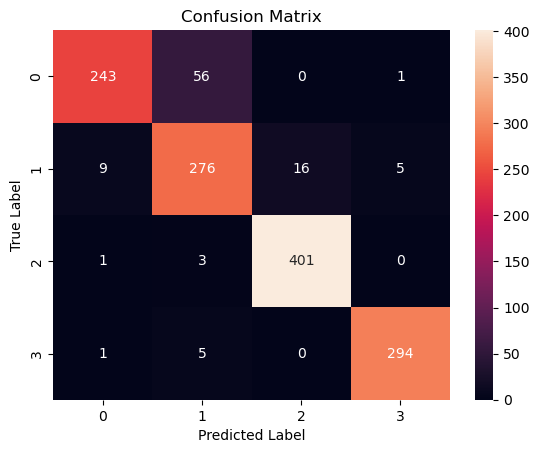

In [43]:
accuracy = accuracy_score(np.argmax(y_test,axis=1), y_pred)
print("Testing Accuracy: {:.2f}%".format(accuracy*100))

print(classification_report(np.argmax(y_test,axis=1), y_pred))

cm = confusion_matrix(np.argmax(y_test,axis=1), y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [44]:
loss, acc, prec, rec = model.evaluate(X_test,y_test)

41/41 [==============================] - 20s 463ms/step - loss: 0.1976 - accuracy: 0.9260 - precision: 0.9301 - recall: 0.9237
